# Telecom Churn Prediction - Modelling

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle

In [2]:
data = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
y = data['Churn']
X = data.drop(labels=['customerID','Churn'], axis=1)

In [4]:
y = y.map({"Yes": 1, "No": 0})

In [5]:
X['TotalCharges'] = X['TotalCharges'].replace(' ', '0')
X['TotalCharges'] = X['TotalCharges'].astype('float')

In [6]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [62]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #Train Test split
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=241) #Train Test split
cv = StratifiedShuffleSplit(test_size=0.2, random_state=321) # Cross validation scheme for hp tuning

In [63]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                 'Contract', 'PaperlessBilling', 'PaymentMethod']

num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

In [64]:
cat_pipe = Pipeline([
                        ('selector', ColumnTransformer([('select_cat', 'passthrough', cat_features)])),
                        ('onehot', OneHotEncoder())
])

num_pipe = Pipeline([
                        ('selector', ColumnTransformer([('select_cat', 'passthrough', num_features)])),
                        ('scaler', StandardScaler())

])

preprocess_pipe = FeatureUnion([
                            ('cat', cat_pipe),
                            ('num', num_pipe)
])

In [65]:
def construct_pipeline(classifier, preprocessor):
    '''constructs pipeline object by combining a preprocessing stage and an estimator
    Args:
        classifier: Estimator object
        preprocessor: Preprocessing transformer object
        
    Returns:
        pipeline object
    '''
    full_pipe = Pipeline([('preprocess', preprocessor),
                        ('clf', classifier )])
    return full_pipe

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    recall  = recall_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_pred)
    print("Recall: ", recall)
    print("ROC - AUC: ", roc)

    return recall, roc

def tune_model(model, param_grid, X_train, y_train, cv = cv, score = "roc_auc"):
    '''Do hyper parameter tuning using GridSearch strategy
    
    Args:
        model: Model to be tuned
        param_grid: dict of parameters
        X_train: Feature matrix
        y_train: Label matrix
        
    Returns: 
        best parameters
        best estimator
    '''
    search = GridSearchCV(model, param_grid = param_grid,
                          cv = cv,
                          scoring=score,
                          return_train_score=True)
    search.fit(X_train, y_train)
    
    print("Best parameters: ", search.best_params_)
    print("-------------------Best model performance(Cross validated) --------------------------")
    
    mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
    mean_test_score = search.cv_results_['mean_test_score'][search.best_index_]
    std_train_score = search.cv_results_['std_train_score'][search.best_index_]
    std_test_score = search.cv_results_['std_test_score'][search.best_index_]

    print(f"Score of the model on the train set:\n"
        f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

    print(f"Score of the model on the test set:\n"
        f"{mean_test_score:.3f} +/- {std_test_score:.6f}")
    print("------------------------------------------------------------------------------------")
    
    return search.best_estimator_


## Baseline models

### Naive Baseline

In [66]:
model = construct_pipeline(DummyClassifier(strategy='stratified'), preprocess_pipe)
model.fit(X_train_full, y_train_full)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.25888324873096447
ROC - AUC:  0.5077667475181916


### Nearest Neighbours (KNN)

#### With default parameters

In [67]:
model = construct_pipeline(KNeighborsClassifier(), preprocess_pipe)
model.fit(X_train_full, y_train_full)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.5152284263959391
ROC - AUC:  0.689633917631467


#### Tuning the parameters

In [68]:
param_grid = {"clf__n_neighbors": range(41, 50, 2)}
tuned_knn = tune_model(model, param_grid, X_train_full, y_train_full)
_ = evaluate_model(tuned_knn, X_test, y_test)

Best parameters:  {'clf__n_neighbors': 49}
-------------------Best model performance(Cross validated) --------------------------
Score of the model on the train set:
0.849 +/- 0.003047
Score of the model on the test set:
0.825 +/- 0.015152
------------------------------------------------------------------------------------
Recall:  0.5786802030456852
ROC - AUC:  0.7321972443799855


## Linear Models

### Logistic Regression

In [69]:
model = construct_pipeline(LogisticRegression(max_iter=1000, solver="saga"), preprocess_pipe)
model.fit(X_train_full, y_train_full)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.5609137055837563
ROC - AUC:  0.7331662123977895


#### Tuning penalty

In [70]:
param_grid = {"clf__C": (1e-2, 1e-1, 1, 10, 15, 20, 25, 30, 100),
            "clf__penalty": ("l1", "l2")}
tuned_log_reg = tune_model(model, param_grid, X_train_full, y_train_full)
_ = evaluate_model(tuned_log_reg, X_test, y_test)

/home/viswajith/.local/share/virtualenvs/churn_prediction-S17WP2eW/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/churn_prediction-S17WP2eW/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/churn_prediction-S17WP2eW/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/churn_prediction-S17WP2eW/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/churn_prediction-S17WP2eW/lib/pytho

Best parameters:  {'clf__C': 25, 'clf__penalty': 'l2'}
-------------------Best model performance(Cross validated) --------------------------
Score of the model on the train set:
0.849 +/- 0.002808
Score of the model on the test set:
0.838 +/- 0.012149
------------------------------------------------------------------------------------
Recall:  0.5685279187817259
ROC - AUC:  0.7345102648095821


#### Tuning threshold

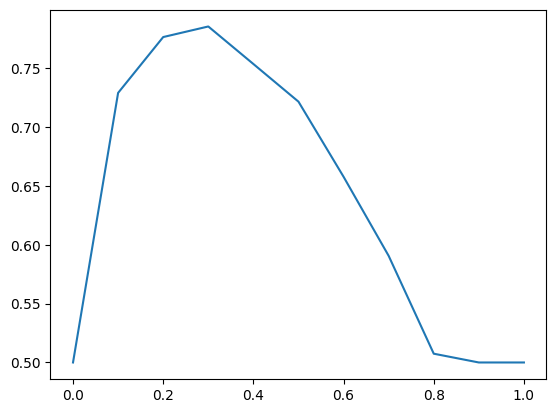

In [79]:
tuned_model = construct_pipeline(LogisticRegression(max_iter=1000, solver="saga"), preprocess_pipe)
tuned_model.fit(X_train, y_train)

thresholds = np.linspace(0, 1, 11)
roc_scores = []
proba = tuned_log_reg.predict_proba(X_val)[:, 1]
for thresh in thresholds:
    y_pred =  np.where(proba >= thresh, 1, 0)
    roc = roc_auc_score(y_val, y_pred)
    roc_scores.append(roc)
plt.plot(thresholds, roc_scores)

In [80]:
proba = tuned_log_reg.predict_proba(X_test)[:, 1]
thresh = 0.3
y_pred = np.where(proba >= thresh, 1, 0)
recall = recall_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
print("Recall: ", recall)
print("ROC - AUC: ", roc)

Recall:  0.7817258883248731
ROC - AUC:  0.7750993973644069


### Support vector machines

In [44]:
model = construct_pipeline(LinearSVC(max_iter=1500), preprocess_pipe)
model.fit(X_train, y_train)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.5634517766497462
ROC - AUC:  0.7354204696056613


In [82]:
param_grid = {"clf__C": (1e-3, 1e-2, 1e-1, 1, 10, 100)}
tuned_svm = tune_model(model, param_grid, X_train, y_train)
_ = evaluate_model(tuned_svm, X_test, y_test)

Best parameters:  {'clf__C': 10}
-------------------Best model performance(Cross validated) --------------------------
Score of the model on the train set:
0.844 +/- 0.004139
Score of the model on the test set:
0.838 +/- 0.016177
------------------------------------------------------------------------------------
Recall:  0.5710659898477157
ROC - AUC:  0.7377497436923307


## Decision tree

In [84]:
model = construct_pipeline(DecisionTreeClassifier(), preprocess_pipe)
model.fit(X_train_full, y_train_full)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.5076142131979695
ROC - AUC:  0.6641519341851916


In [89]:
param_grid = {"clf__max_depth": (3, 4, 5, 6, 7, 8),
            "clf__min_samples_split": (2, 3, 4, 5, 6)}
tuned_tree = tune_model(model, param_grid, X_train, y_train)
_ = evaluate_model(tuned_tree, X_test, y_test)

Best parameters:  {'clf__max_depth': 4, 'clf__min_samples_split': 3}
-------------------Best model performance(Cross validated) --------------------------
Score of the model on the train set:
0.839 +/- 0.003480
Score of the model on the test set:
0.826 +/- 0.015148
------------------------------------------------------------------------------------
Recall:  0.4746192893401015
ROC - AUC:  0.6905116151134005


## Ensemble Methods

### Random Forest

In [99]:
model = construct_pipeline(RandomForestClassifier(), preprocess_pipe)
model.fit(X_train_full, y_train_full)
_ = evaluate_model(model, X_test, y_test)

Recall:  0.47715736040609136
ROC - AUC:  0.6922732614838338


In [100]:
param_grid = {"clf__n_estimators": (50, 100, 200, 300, 400),
            "clf__max_depth": (3, 4, 5, 6, 7, 8),
            "clf__min_samples_split": (2, 3, 4, 5, 6)}
tuned_rf = tune_model(model, param_grid, X_train, y_train)
_ = evaluate_model(tuned_rf, X_test, y_test)

Best parameters:  {'clf__max_depth': 6, 'clf__min_samples_split': 5, 'clf__n_estimators': 300}
-------------------Best model performance(Cross validated) --------------------------
Score of the model on the train set:
0.876 +/- 0.003245
Score of the model on the test set:
0.842 +/- 0.016335
------------------------------------------------------------------------------------
Recall:  0.4720812182741117
ROC - AUC:  0.6971243529794203


## Saving the best model

### Retraining on the full dataset

In [102]:
final_model = construct_pipeline(LogisticRegression(C = 25, max_iter=1000, solver="saga"), preprocess_pipe)
final_model.fit(X, y)

Pipeline(steps=[('preprocess',
                 FeatureUnion(transformer_list=[('cat',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('select_cat',
                                                                                                   'passthrough',
                                                                                                   ['gender',
                                                                                                    'SeniorCitizen',
                                                                                                    'Partner',
                                                                                                    'Dependents',
                                                                                                    'PhoneService',
                                                                                                    'MultipleLines',
                                                                                                    'InternetService',
                                                                                                    'OnlineSecurity',
                                                                                                    'OnlineBackup',
                                                                                                    'DeviceProtection',
                                                                                                    'TechSupport',
                                                                                                    'StreamingTV',
                                                                                                    'StreamingMovies',
                                                                                                    'Contract',
                                                                                                    'PaperlessBilling',
                                                                                                    'PaymentMethod'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('num',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnTransformer(transformers=[('select_cat',
                                                                                                   'passthrough',
                                                                                                   ['tenure',
                                                                                                    'MonthlyCharges',
                                                                                                    'TotalCharges'])])),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('clf',
                 LogisticRegression(C=25, max_iter=1000, solver='saga'))])

In [103]:
with open("churn_model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)